# Problem Set 5

As usual, you are highly encouraged to *start this problem set early!*  Our best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

In addition to numpy, pandas, sklearn and matplotlib, we suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life much easier:-

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block. You may also import additional functions/classes if you need them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#You can go over the scikit-learn documentation to learn more about what some of these functions and classes
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import IPython

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  We have downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  We have also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies.

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for 2020's [Oscar winner](https://www.rottentomatoes.com/m/parasite_2019) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Let's start by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')
movies = movies.dropna()
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews = reviews[~reviews.critic.isna()]

### 1.1: Basic features of the dataset

Answer the following questions by having your Python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many different publications have reviews in the `reviews` dataset?
* How many unique movies are in the `movies` dataset?
* What is the year range in the `movies` dataset? 
* What is the lowest `rtAudienceScore` for the year 1995 in the `movies` dataset?


In [3]:
# unique reviews (quotes)
len(reviews['quote'].unique())

12149

In [4]:
#unique reviewers (critics)
len(reviews['critic'].unique())

540

In [5]:
#unique movies
len(reviews['title'].unique())

1715

In [6]:
#different publications
len(reviews['publication'].unique())

64

In [7]:
#unique movies are in the movies
len(movies['title'].unique())

8959

In [8]:
#year range in the movies
movies['year'].max() - movies['year'].min()

108

In [9]:
#the lowest rtAudienceScore for the year 1995 in the movies
df_95 = movies[['rtAudienceScore', 'year']]
df_95.loc[df_95['year'] == 1995].sort_values(by='rtAudienceScore').min()

rtAudienceScore       0
year               1995
dtype: object

### 1.2 Number of reviews per critic

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per critic.  Have the bin width (x-axis) be 5 units wide, and the range of the x-axis to be from 0 to 100.  Scale the y-axis to show the logarithm of the (count of) the number of critics.  Also add a vertical line at the average number of reviews per critic. 

Label your axes and make your histogram look professional.

<ipython-input-10-e5e833ae83fa>:8: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


Text(0.5, 1.0, 'Histogram Plot of the number of reviews per critic')

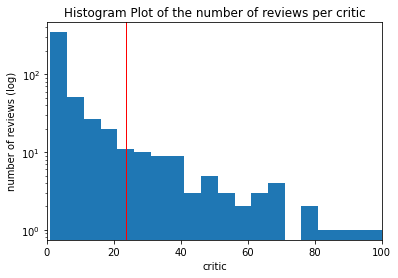

In [10]:
# the distribution of the number of reviews per critic
df_cr = reviews[['critic']].value_counts()

import matplotlib.pyplot as plt

#range of x_axis, logarithm y_axis
plt.xlim(xmin=0, xmax = 100)
plt.yscale('log', nonposy='clip')

#bin width be 5 units wide
binwidth = 5
plt.hist(df_cr, bins = np.arange(min(df_cr), max(df_cr) + binwidth, binwidth))

plt.axvline(df_cr.mean(), color='r', linewidth=1)

plt.xlabel('critic')
plt.ylabel('number of reviews (log)')
plt.title('Histogram Plot of the number of reviews per critic')

### 1.3 Zoom in on a few reviewers
Find the 25 critics with the most reviews, and list their names in a table along with -

* (a) The name(s) of *all* the publications they work for. If a critic happens to work for more than one publication, you should have a comma-separated string that contains all publications for that critic.
* (b) The date of their first review.
* (c) The date of their last review.
* (d) The total number of reviews (count).

Sort the table in descending order of the number of reviews.

*Hint: The `apply`, `merge` and `groupby` functions can be useful here*

In [11]:
# create dataframe with top 25 critics count
df_top25 = df_cr.iloc[0:25].to_frame()
df_top25 = df_top25.reset_index()
df_top25.columns = ['critic', 'count']
df_top25['publication'] = np.nan
df_top25['first review'] = np.nan
df_top25['last review'] = np.nan

In [12]:
top_25_list = df_top25['critic'].to_list()
first_review = []
last_review = []
publication = []

for name in top_25_list:
    re = reviews[reviews['critic'] == name]
    pub = re['publication'].unique().tolist()
    
    #append the min date of review
    min_date = min(re['review_date'])
    first_review.append(min_date)
    
    #append the max data of review
    max_date = max(re['review_date'])
    last_review.append(max_date)
    
    #concatenate publications
    str1 = ', '.join(pub)

    publication.append(str1)

In [13]:
#convert lists to pd.series and append to df
last_review = pd.Series(last_review)
df_top25['last review'] = last_review

first_review = pd.Series(first_review)
df_top25['first review'] = first_review

publication = pd.Series(publication)
df_top25['publication'] = publication
df_top25

,critic,count,publication,first review,last review
0,Roger Ebert,1150,"Chicago Sun-Times, At the Movies",2000-01-01 00:00:00,2013-06-11 00:00:00
1,James Berardinelli,833,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
2,Janet Maslin,526,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
3,Variety Staff,449,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
4,Jonathan Rosenbaum,420,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
5,Desson Thomson,373,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
6,Geoff Andrew,361,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
7,Dave Kehr,360,"Chicago Reader, New York Daily News, Chicago T...",2000-01-01 00:00:00,2013-11-20 00:00:00
8,Kenneth Turan,282,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
9,Mick LaSalle,280,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average movie rating has evolved over time. Refer to `rtAllCriticsRating` for each movie's rating. 

Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is `rtAllCriticsRating`.  Drop movies with 0 or unknown values to simplify the analysis.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of `rtAllCriticsRating` across all movies in a year) has changed over time.  

Do you notice a trend?  What do you think it means?

In [14]:
#create df for plotting
plot1 = movies[['title', 'year','rtAllCriticsRating']]
plot1 = plot1.astype({'rtAllCriticsRating': np.float})
plot1_filter = plot1[plot1['rtAllCriticsRating'] != 0.0]
plot1_filter

,title,year,rtAllCriticsRating
0,Toy story,1995,9.0
1,Jumanji,1995,5.6
2,Grumpy Old Men,1993,5.9
3,Waiting to Exhale,1995,5.6
4,Father of the Bride Part II,1995,5.3
...,...,...,...
9414,Pete Seeger: The Power of Song,2007,8.2
9418,Ben X,2007,6.3
9419,Bedtime Stories,2008,4.4
9420,Manhattan Melodrama,1934,7.0


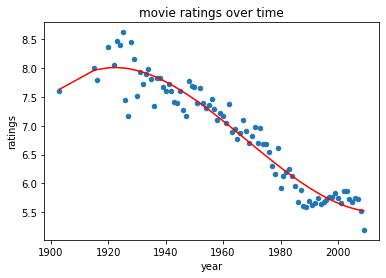

In [15]:
#plot the graph
rating_over_time  = plot1_filter.groupby('year')['rtAllCriticsRating'].mean()
df = rating_over_time.to_frame()
df.reset_index(inplace = True)
df.columns = ['year', 'ratings']
df.plot(kind= 'scatter', x= 'year', y= 'ratings')

p = np.polyfit(df.year, df.ratings, 3)
plt.plot(df.year,np.polyval(p, df.year),'r-')
plt.title('movie ratings over time')
plt.show()

Based on the trend that show in the graph, the average rating of movies is decreasing over the years. Probably because people are more critical or the production quality of films decreased over time indeed. 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is:-\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:-")
print(vectorizer.get_feature_names())

Original text is:-
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:-
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where -
    
 * X is an **(nreview, nwords)** array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is an **nreview**-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text, if any. 

In [110]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer):
    #subset the dataframe
    df_bow = reviews[['quote','fresh']]
    
    # Data of fresh is converted into Binary Data
    df_one = pd.get_dummies(df_bow["fresh"])
    # Binary Data is Concatenated into Dataframe
    df_two = pd.concat((df_one, df_bow), axis=1)
    # rename columns
    df_two.columns = ['output', 'rotten', 'quote','fresh']
    # columns droped
    df_two = df_two.drop(["fresh"], axis=1)
    y = df_two.drop(["rotten"], axis=1)
    #output y
    Y = y['output'].to_numpy()
    
    #checking vectorizer parameter
    if vectorizer == None:
        count_v = CountVectorizer(min_df = 0)
    else:
        count_v = vectorizer
    
    w = count_v.fit(df_bow['quote'])
    w = count_v.transform(df_bow['quote'])
    X = w.toarray()

    return X, Y

In [111]:
X, Y = make_xy(reviews, vectorizer = None)

In [112]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [113]:
X.shape

(12718, 20267)

In [114]:
Y.shape

(12718,)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set, or use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  If you use `train_test_split`, set the `random_state` to 42, and have the split be stratified.

In [103]:
# a training set (80%) and a validation set (20%)
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= .2, random_state = 42, stratify= Y)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results.

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [107]:
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train, y_train)

#predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

#accuracy score 
train_pred_score = accuracy_score(y_train, y_train_pred)
test_pred_score = accuracy_score(y_test, y_test_pred)

print('Training Set Accuracy Score: \n', (100 * train_pred_score))
print('Testing Set Accuracy Score: \n', (100 * test_pred_score))

Training Set Accuracy Score: 
 92.70689994102614
Testing Set Accuracy Score: 
 76.69025157232704


- the training set has a higher accuracy score of 92.7%, since we fit the data on the training data;
- the testing set has a lower accuracy score or 76.7%

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on bcourses).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [27]:
# Enter your code here

--------------------------------------------

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [28]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(clf, X_test, y_test)

-1484.6226919350693

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our methods have a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha`](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) keyword in the Bayesian classifier is the "smoothing parameter" that we discussed in class -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

How does the choice of these hyperparameters affect the performance of the model?

*Hints:* 
* sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here. You can use 5-fold CV. If you go this route, you'll want to set the scoring function to be the custom likelihood function defined earlier.
* For CV we only use the training set. This means in every iteration, for every combination of alpha and min_df, you will need to re-split into training and test sets. 

In [115]:
#You will want to suppress the warnings, since there might be a lot of them in this block. If you want to view them, change
# the 'ignore' to 'default' or 'once'
import warnings
warnings.filterwarnings('ignore')


#the grid of parameters to search over
alphas = [0, 1, 5, 10, 50]
min_dfs = [0.0001,0.001,0.01, 0.1, 0.2]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    
    print('alpha is : ' + str(alpha))
    
    for min_df in min_dfs:
        
        print('min_df is : ' + str(min_df))
        
        #initialize vecotizer 
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #train test split
        X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= .2, random_state = 42, stratify= Y)
        
        #initialize NB model
        clf = MultinomialNB(alpha = alpha)

        #cross validating the NB model using 5 cv
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring = log_likelihood)
        mean_score = score.mean()
        print('log scores: {:.2f}'.format(np.mean(score)))
        
        #updating the best parameters
        if mean_score > max_loglike:
            max_loglike = np.mean(score)
            best_alpha = alpha
            best_min_df = min_df

print("best alpha, best min_dfs: ",best_alpha, best_min_df)

alpha is : 0
min_df is : 0.0001
log scores: -12041.87
min_df is : 0.001
log scores: -1969.26
min_df is : 0.01
log scores: -1266.58
min_df is : 0.1
log scores: -1323.94
min_df is : 0.2
log scores: -1330.68
alpha is : 1
min_df is : 0.0001
log scores: -1126.97
min_df is : 0.001
log scores: -1150.83
min_df is : 0.01
log scores: -1265.55
min_df is : 0.1
log scores: -1323.94
min_df is : 0.2
log scores: -1330.68
alpha is : 5
min_df is : 0.0001
log scores: -1478.95
min_df is : 0.001
log scores: -1095.86
min_df is : 0.01
log scores: -1262.56
min_df is : 0.1
log scores: -1323.91
min_df is : 0.2
log scores: -1330.69
alpha is : 10
min_df is : 0.0001
log scores: -2138.36
min_df is : 0.001
log scores: -1138.96
min_df is : 0.01
log scores: -1260.68
min_df is : 0.1
log scores: -1323.89
min_df is : 0.2
log scores: -1330.69
alpha is : 50
min_df is : 0.0001
log scores: -3192.36
min_df is : 0.001
log scores: -1949.58
min_df is : 0.01
log scores: -1280.73
min_df is : 0.1
log scores: -1323.94
min_df is : 0.

How does the choice of these hyperparameters affect the performance of the model?
- its the combination of both alpha and min_df that yields to different accuracy score. 

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy on training and test sets.  Discuss the various ways in which cross-validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [116]:
best_alpha = 5
best_min_df = 0.001

#final vectorizer model and X, Y data
vectorizer_final = CountVectorizer(min_df = best_min_df)       
X_final, Y_final = make_xy(reviews, vectorizer_final)

#train-test split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, Y_final, test_size= .2, random_state = 42, stratify= Y_final)

#fit NB model on the training datasets
clf_final = MultinomialNB(alpha = best_alpha)
clf_final.fit(X_train_final, y_train_final)

#predict y on training data
y_train_pred = clf_final.predict(X_train_final)

#predict y on testing data
y_test_pred = clf_final.predict(X_test_final)

#accuracy score for training and testing predictions
test_pred_score = accuracy_score(y_test_final, y_test_pred)
train_pred_score = accuracy_score(y_train_final, y_train_pred)

print('Training set Accuracy Score: \n', (100 * train_pred_score))
print('Testing set Accuracy Score: \n', (100 * test_pred_score))

Training set Accuracy Score: 
 79.72282288185572
Testing set Accuracy Score: 
 72.6808176100629


- The overall accuracy score improved slightly. The training accuracy 79.72% is higher than the testing  accuracy 72.68%. Overfitting is bad since we might be losing information and accuracy on the actual testing data if we overfit on the training data. 

### 3.4 (EXTRA CREDIT) 

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [118]:
from sklearn.metrics import balanced_accuracy_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

#the grid of parameters to search over
alphas = [0, 1, 5, 10, 50]
min_dfs = [0.0001,0.001,0.01, 0.1, 0.2]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_accuracy_score = -np.inf

for alpha in alphas:
    
    print('alpha is : ' + str(alpha))
    
    for min_df in min_dfs:
        
        print('min_df is : ' + str(min_df))
        
        #initialize vecotizer 
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #train test split
        X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= .2, random_state = 42, stratify= Y)
        
        #initialize NB model
        clf = MultinomialNB(alpha = alpha)

        #cross validating the NB model using 5 cv
        scorer = make_scorer(balanced_accuracy_score)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring = scorer)
        mean_score = score.mean()
        print('accuracy scores: {:.2f}'.format(np.mean(score)))
        
        #updating the best parameters
        if mean_score > max_accuracy_score:
            max_accuracy_score = np.mean(score)
            best_alpha = alpha
            best_min_df = min_df

print("best alpha, best min_dfs: ",best_alpha, best_min_df)

alpha is : 0
min_df is : 0.0001
accuracy scores: 0.70
min_df is : 0.001
accuracy scores: 0.72
min_df is : 0.01
accuracy scores: 0.61
min_df is : 0.1
accuracy scores: 0.51
min_df is : 0.2
accuracy scores: 0.51
alpha is : 1
min_df is : 0.0001
accuracy scores: 0.75
min_df is : 0.001
accuracy scores: 0.72
min_df is : 0.01
accuracy scores: 0.61
min_df is : 0.1
accuracy scores: 0.52
min_df is : 0.2
accuracy scores: 0.51
alpha is : 5
min_df is : 0.0001
accuracy scores: 0.63
min_df is : 0.001
accuracy scores: 0.71
min_df is : 0.01
accuracy scores: 0.61
min_df is : 0.1
accuracy scores: 0.51
min_df is : 0.2
accuracy scores: 0.51
alpha is : 10
min_df is : 0.0001
accuracy scores: 0.54
min_df is : 0.001
accuracy scores: 0.67
min_df is : 0.01
accuracy scores: 0.61
min_df is : 0.1
accuracy scores: 0.51
min_df is : 0.2
accuracy scores: 0.51
alpha is : 50
min_df is : 0.0001
accuracy scores: 0.50
min_df is : 0.001
accuracy scores: 0.51
min_df is : 0.01
accuracy scores: 0.58
min_df is : 0.1
accuracy scor

In [119]:
#final vectorizer model and X, Y data
vectorizer_final_2 = CountVectorizer(min_df = 0.0001)       
X_final_2, Y_final_2 = make_xy(reviews, vectorizer_final_2)

#train-test split
X_train_final_2, X_test_final_2, y_train_final_2, y_test_final_2 = train_test_split(X_final_2, Y_final_2, test_size= .2, random_state = 42, stratify= Y_final_2)

#fit NB model on the training datasets
clf_final_2 = MultinomialNB(alpha = 1)
clf_final_2.fit(X_train_final_2, y_train_final_2)

#predict y on training data
y_train_pred_2 = clf_final_2.predict(X_train_final_2)

#predict y on testing data
y_test_pred_2 = clf_final_2.predict(X_test_final_2)

#accuracy score for training and testing predictions
test_pred_score_2 = accuracy_score(y_test_final_2, y_test_pred_2)
train_pred_score_2 = accuracy_score(y_train_final_2, y_train_pred_2)

print('Training set Accuracy Score: \n', (100 * train_pred_score_2))
print('Testing set Accuracy Score: \n', (100 * test_pred_score_2))

Training set Accuracy Score: 
 90.819736583448
Testing set Accuracy Score: 
 76.41509433962264


Using a different accuracy function we got different optimun alpha and min_df value. Potentially we have a overfitting on the training data, since the training accuracy is a lot higher than the testing set data.

Overally, this new set of min_df and alpha value increased the accuracy score. The testing data accuracy improved from 72.68% to 76.415%

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method (classifier and vectorizer from 3.3), determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [120]:
X_final_df = pd.DataFrame(X_final)
X_final_df

,0,1,2,3,4,5,6,7,8,9,...,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
import numpy as ppool

#identity matrix with the size of the features
a = ppool.identity(12718).astype('int64')
proba_a = clf_final.predict_proba(X_final)
word_prob_df = pd.DataFrame(proba_a, columns= ['Rotten', 'fresh'])

In [124]:
features = vectorizer_final.get_feature_names()
#output the df with the prob and word features
features_series = pd.Series(features)
word_prob_df['word'] = features_series
word_prob_df

,Rotten,fresh,word
0,0.078096,0.921904,10
1,0.104250,0.895750,100
2,0.064784,0.935216,1961
3,0.010706,0.989294,1998
4,0.018696,0.981304,20
...,...,...,...
12713,0.007986,0.992014,NaN
12714,0.883924,0.116076,NaN
12715,0.857707,0.142293,NaN
12716,0.061004,0.938996,NaN


In [125]:
word_no_nan = word_prob_df.dropna(axis=0)
word_no_nan

,Rotten,fresh,word
0,0.078096,0.921904,10
1,0.104250,0.895750,100
2,0.064784,0.935216,1961
3,0.010706,0.989294,1998
4,0.018696,0.981304,20
...,...,...,...
2221,0.974334,0.025666,your
2222,0.529130,0.470870,yourself
2223,0.521391,0.478609,youth
2224,0.257037,0.742963,zemeckis


In [126]:
#top 10 words that gave the fresh review
top_fresh_pred = word_no_nan.sort_values(by = 'fresh', ascending= False)
top_fresh_pred.head(10)

,Rotten,fresh,word
1614,0.000016,0.999984,rousing
194,0.000158,0.999842,between
5,0.000402,0.999598,30
1159,0.000415,0.999585,magic
1760,0.000422,0.999578,so
1357,0.000442,0.999558,or
293,0.000483,0.999517,caught
308,0.000668,0.999332,charming
1851,0.000674,0.999326,strong
990,0.000848,0.999152,innocence


In [127]:
#top 10 words that gave the rotten review
top_rotten_pred = word_no_nan.sort_values(by = 'Rotten', ascending= False)
top_rotten_pred.head(10)

,Rotten,fresh,word
1103,0.999960,0.000040,length
1105,0.999433,0.000567,less
1893,0.999120,0.000880,suspenseful
321,0.998897,0.001103,cinema
158,0.998819,0.001181,banal
1200,0.997648,0.002352,measure
1913,0.997383,0.002617,target
2008,0.997317,0.002683,travel
1128,0.996229,0.003771,little
882,0.996161,0.003839,hanks


### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [129]:
#predict the final Y
Y_pred_final = clf_final.predict(X_final)

#get the probability distribution for Y prediction
proba = clf_final.predict_proba(X_final)
proba

array([[0.07809573, 0.92190427],
       [0.10425017, 0.89574983],
       [0.0647839 , 0.9352161 ],
       ...,
       [0.85770743, 0.14229257],
       [0.06100421, 0.93899579],
       [0.70181714, 0.29818286]])

In [130]:
#create df for the output and set the check as whether the prediction is correct or not
data_error = pd.DataFrame(proba, columns= ['Rotten', 'fresh'])
check = Y_pred_final  == Y_final

data_error['y predicted'] = pd.DataFrame(Y_pred_final )
data_error['y true'] = pd.DataFrame(Y_final)
data_error['correct'] = pd.DataFrame(check)
#data_error['word'] = features_series
data_error['review'] = reviews['quote']

In [131]:
#top 5 words that gave the wrong fresh prediction 
false_pred = data_error[data_error['correct'] == False]
fals_pred_drop = false_pred.dropna(axis=0)

false_fresh_pred = fals_pred_drop.sort_values(by = 'fresh', ascending= False)
false_fresh_pred.head(5)

,Rotten,fresh,y predicted,y true,correct,review
4878,0.002983,0.997017,1,0,False,An epic achievement in filmmaking.
5968,0.004184,0.995816,1,0,False,Scream builds to a splattering finale that sho...
12684,0.006434,0.993566,1,0,False,The movie haunts you like a ballad whose tune ...
5350,0.006670,0.993330,1,0,False,It isn't often that extremely clever moviemake...
6876,0.007649,0.992351,1,0,False,There has never been a film quite like Kasi Le...


In [133]:
#top 5 words that gave the wrong rotten prediction 
false_rotten_pred = fals_pred_drop.sort_values(by = 'Rotten', ascending= False)
false_rotten_pred.head(5)

,Rotten,fresh,y predicted,y true,correct,review
5125,0.996646,0.003354,0,1,False,Bergman's visually striking medieval morality ...
2054,0.995534,0.004466,0,1,False,Where's John McClane when you need him? If not...
8154,0.994441,0.005559,0,1,False,The restoration eliminates nearly all the dist...
1647,0.994093,0.005907,0,1,False,Reduces the tumult of the last few decades to ...
642,0.991052,0.008948,0,1,False,Man of the Year isn't Movie of the Year. It mi...


In [136]:
s = "This movie is not remarkable, touching, or superb in any way"
# call `transform` to convert text to a bag of words
s_t = vectorizer_final.transform([s]).toarray()

print("Transformed text vector is \n", s_t)

Transformed text vector is 
 [[0 0 0 ... 0 0 0]]



In [139]:
proba_s = clf_final.predict_proba(s_t)
proba_s

array([[0.02231255, 0.97768745]])

- What do you notice about these mis-predictions? 
    That most of the comments have to be interpreted within context, and even some of them contains strong negative/positive word, it could means the opposite based on the sentence structure. Therefore, it's hard for model to make precise prediction solely based on independent words' probability


- In what way is this a bad assumption? 
    Because the Naive Bayes classifiers assume every word affects the freshness probability independently of other words, some words are more importent in context than the others, for example, in the phase 'not good', the word 'not' is more important than 'good', but if we give each word an eqaul probability, than it might make a wrong prediction based sorely on the word 'good'. 


- In your answer, report your classifier's Freshness probability: 97.76%. which cause problems since the weighting on the word 'not' should be dominant, even there're multiple positive words present. 

### 3.7 (EXTRA CREDIT)  Word2Vec

Let's try something different now.

[Word2Vec](https://en.wikipedia.org/wiki/Word2vec) is a popular algorithm based on a shallow neural network, that can use large amounts of unannotated plain text, to learn relationships between words automatically. This is often very useful in recommender systems, text tagging or machine translation. Let's try to implement a basic version of this for our reviews data and observe some interesting (and natural) relationships between words. 

You will be using a new dataset which contains IMDB reviews, since we need a sufficiently large dataset and the Rotten Tomatoes dataset we have won't suffice. Download the data from [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). Train a Word2Vec model on these reviews and try to do the following - 

* From 3.5, pick 3 words that best predict a "fresh" review, and another 3 words that best predict a "rotten" review. For each of these words, find and print the top 10 most similar words from the vocabulary. 
* Spot the odd one out! Use the model to find the odd word from each of these input lists of words- 
    * 'amazing','great','awesome','horrible'
    * 'movie','cinema','theater','box'
    * 'car','bike','ball','bus'
    
    
Do you think this model is able to learn representations of words within a given context? Feel free to play around with the model and report any other interesting findings.


NOTE - 
* You should use the [*gensim*](https://radimrehurek.com/gensim/index.html) library for this question. [This](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) link contains all the details you need to get familarized with Word2Vec.
* It is highly recommended to pre-process your input data before feeding it to the model. Most common pre-processing steps include changing to lower case, removing punctuations, removing non-alphabetic tokens and removing stop words. You may find the [*nltk*](https://www.nltk.org/) library very useful for this, but feel free to use any other library. You can run the below block to import these libraries (you may have to pip install if you do not have these already installed).
* gensim provides access to pre-trained models ; **do not use a pre-trained model**. You should train the model yourself, and this will not take too long to run.
* We recommend you set an embedding size of 100-200 and a window of 4 or 5 for the model.

In [ ]:
import string
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import *

In [ ]:
# Enter your code here